In [100]:
!pip install scipy
!pip install numpy
!pip install pandas
!pip install missingno
!pip install -U scikit-learn
!pip install --ignore-installed --upgrade tensorflow 
!pip install keras

In [97]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import missingno as msno
import scipy as sp
from statistics import mode
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from keras import layers, models
from keras.backend import relu
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras import optimizers
from keras import metrics
from sklearn.externals import joblib
from boto.s3.connection import S3Connection, Location
from boto.s3.key import Key
color = sns.color_palette()
pd.options.mode.chained_assignment = None

In [2]:
train16_df = pd.read_csv("..\\Zillow\\train_2016_v2.csv", parse_dates=["transactiondate"])
train16_df['Year'] = '2016'
train16_df.shape

(90275, 4)

In [3]:
train17_df = pd.read_csv("..\\Zillow\\train_2017.csv", parse_dates=["transactiondate"])
train17_df['Year'] = '2017'
train17_df.shape

(77613, 4)

In [75]:
train_df = pd.concat([train16_df,train17_df], ignore_index=True)
train_df.head()

,parcelid,logerror,transactiondate,Year
0,11016594,0.0276,2016-01-01,2016
1,14366692,-0.1684,2016-01-01,2016
2,12098116,-0.0040,2016-01-01,2016
3,12643413,0.0218,2016-01-02,2016
4,14432541,-0.0050,2016-01-02,2016


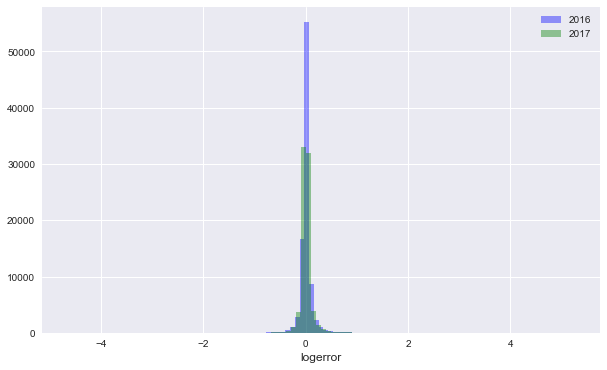

In [73]:
plt.figure(figsize=(10,6))
sns.distplot(train16_df.logerror.values, bins = 100, kde=False, color = "blue", label = "2016")
sns.distplot(train17_df.logerror.values, bins = 100, kde=False, color = "green", label = "2017")
plt.xlabel('logerror', fontsize=12)
plt.legend()
plt.show()

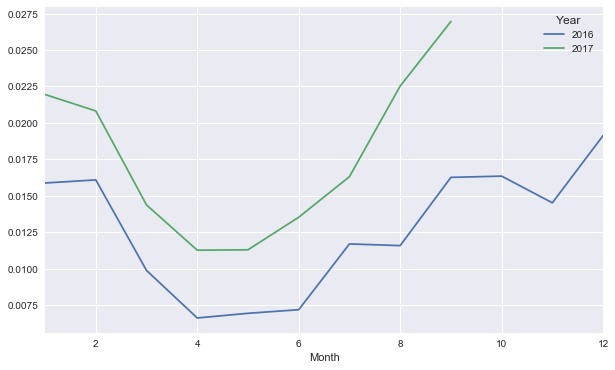

In [6]:
line_df = train_df['logerror'].groupby([train_df.transactiondate.dt.month, train_df.transactiondate.dt.year]).agg('mean').unstack()
line_df.columns.name = 'Year'
line_df.index.name = 'Month'
ax = line_df.plot(kind = 'line',figsize=(10,6))

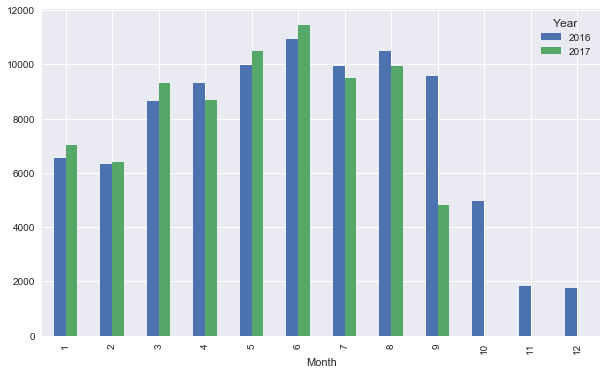

In [7]:
bar_df = train_df['logerror'].groupby([train_df.transactiondate.dt.month, train_df.transactiondate.dt.year]).agg('count').unstack()
bar_df.columns.name = 'Year'
bar_df.index.name = 'Month'
ax = bar_df.plot(kind = 'bar',figsize=(10,6))

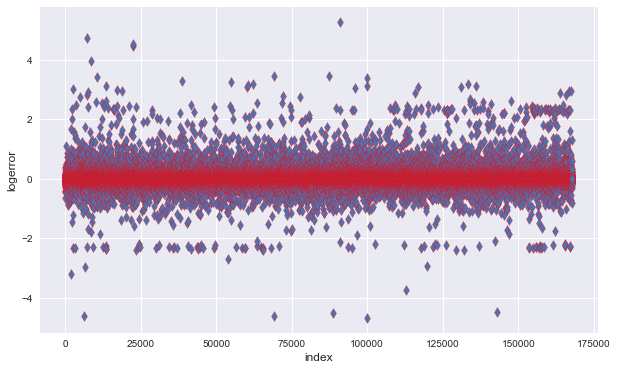

In [76]:
plt.figure(figsize=(10,6))
plt.scatter(range(train_df.shape[0]), train_df.logerror.values,marker='d',edgecolors='red')
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

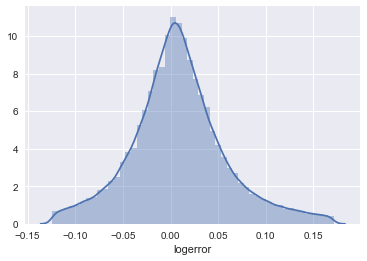

In [77]:
ulimit = np.percentile(train_df.logerror.values, 95)
llimit = np.percentile(train_df.logerror.values, 5)
train_df = train_df[train_df['logerror'] < ulimit]
train_df = train_df[train_df['logerror'] > llimit]
ax = sns.distplot(train_df['logerror'])

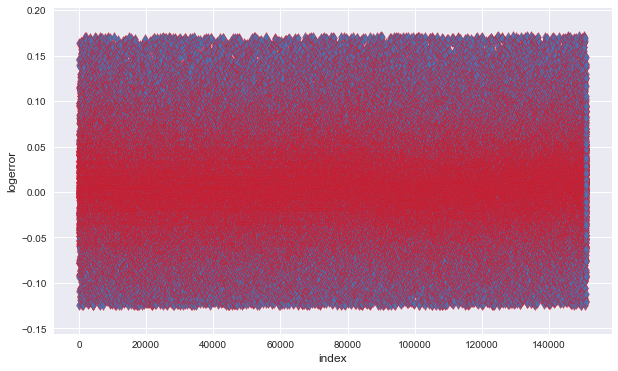

In [78]:
plt.figure(figsize=(10,6))
plt.scatter(range(train_df.shape[0]), train_df.logerror.values,marker='d',edgecolors='red')
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

In [9]:
prop16_df = pd.read_csv("..\\Zillow\\properties_2016.csv", low_memory=False)
prop16_df['Year'] = '2016'
prop16_df.shape

(2985217, 59)

In [10]:
prop17_df = pd.read_csv("..\\Zillow\\properties_2017.csv", low_memory=False)
prop17_df['Year'] = '2017'
prop17_df.shape

(2985217, 59)

In [11]:
prop_df = pd.concat([prop16_df,prop17_df], ignore_index=True)
prop_df.describe()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,yardbuildingsqft26,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock
count,5.970434e+06,1.626881e+06,12122.000000,3255.000000,5.956015e+06,5.956039e+06,25360.000000,3.879883e+06,5.724366e+06,34475.0,...,5293.000000,5.862673e+06,1.367745e+06,5.868988e+06,5.893618e+06,5.956062e+06,5.842775e+06,5.916432e+06,112981.000000,5.820323e+06
mean,1.332586e+07,1.938462e+00,7.202607,647.051920,2.212674e+00,3.091159e+00,3.730363,6.032990e+00,2.301549e+00,66.0,...,278.331003,1.964350e+03,1.401209e+00,1.745185e+05,4.320197e+05,2.015500e+03,2.604776e+05,5.393300e+03,13.892053,6.048433e+13
std,7.909966e+06,3.154574e+00,2.436190,538.707521,1.078008e+00,1.273714e+00,0.501043,1.785322e+00,1.001996e+00,0.0,...,369.723014,2.354339e+01,5.390660e-01,4.320903e+05,7.728019e+05,5.018861e-01,4.663194e+05,9.432917e+03,2.571590,3.249084e+11
min,1.071172e+07,1.000000e+00,2.000000,20.000000,0.000000e+00,0.000000e+00,1.000000,1.000000e+00,1.000000e+00,66.0,...,10.000000,1.801000e+03,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+03,1.000000e+00,2.400000e-01,0.000000,-1.000000e+00
25%,1.164371e+07,1.000000e+00,7.000000,272.000000,2.000000e+00,2.000000e+00,3.000000,4.000000e+00,2.000000e+00,66.0,...,96.000000,1.950000e+03,1.000000e+00,7.617375e+04,1.838422e+05,2.015000e+03,7.726000e+04,2.464850e+03,14.000000,6.037400e+13
50%,1.254509e+07,1.000000e+00,7.000000,535.000000,2.000000e+00,3.000000e+00,4.000000,7.000000e+00,2.000000e+00,66.0,...,168.000000,1.963000e+03,1.000000e+00,1.248200e+05,3.133830e+05,2.016000e+03,1.717350e+05,3.999580e+03,14.000000,6.037572e+13
75%,1.409712e+07,1.000000e+00,7.000000,847.500000,3.000000e+00,4.000000e+00,4.000000,7.000000e+00,3.000000e+00,66.0,...,320.000000,1.981000e+03,2.000000e+00,2.004450e+05,5.010000e+05,2.016000e+03,3.163500e+05,6.215350e+03,15.000000,6.059042e+13
max,1.696019e+08,1.300000e+01,27.000000,8516.000000,3.200000e+01,2.500000e+01,5.000000,1.200000e+01,3.200000e+01,66.0,...,6141.000000,2.016000e+03,4.100000e+01,2.553212e+08,3.196225e+08,2.016000e+03,9.401108e+07,3.823176e+06,99.000000,4.830301e+14


In [12]:
train_df = pd.merge(train_df, prop_df, on=['parcelid','Year'], how='left')
train_df.head()

,parcelid,logerror,transactiondate,Year,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,2016,1.0,NaN,NaN,2.0,3.0,NaN,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,12098116,-0.0040,2016-01-01,2016,1.0,NaN,NaN,3.0,2.0,NaN,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
2,12643413,0.0218,2016-01-02,2016,1.0,NaN,NaN,2.0,2.0,NaN,...,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
3,14432541,-0.0050,2016-01-02,2016,NaN,NaN,NaN,2.5,4.0,NaN,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13
4,12286022,0.0440,2016-01-02,2016,NaN,NaN,NaN,1.0,2.0,NaN,...,NaN,NaN,64549.0,111521.0,2015.0,46972.0,2304.97,NaN,NaN,6.037542e+13


In [13]:
typeCount_df = train_df.dtypes.reset_index().groupby(0).aggregate('count').reset_index()
typeCount_df.columns = ["Type","Count"]
typeCount_df

,Type,Count
0,int64,1
1,float64,53
2,datetime64[ns],1
3,object,6


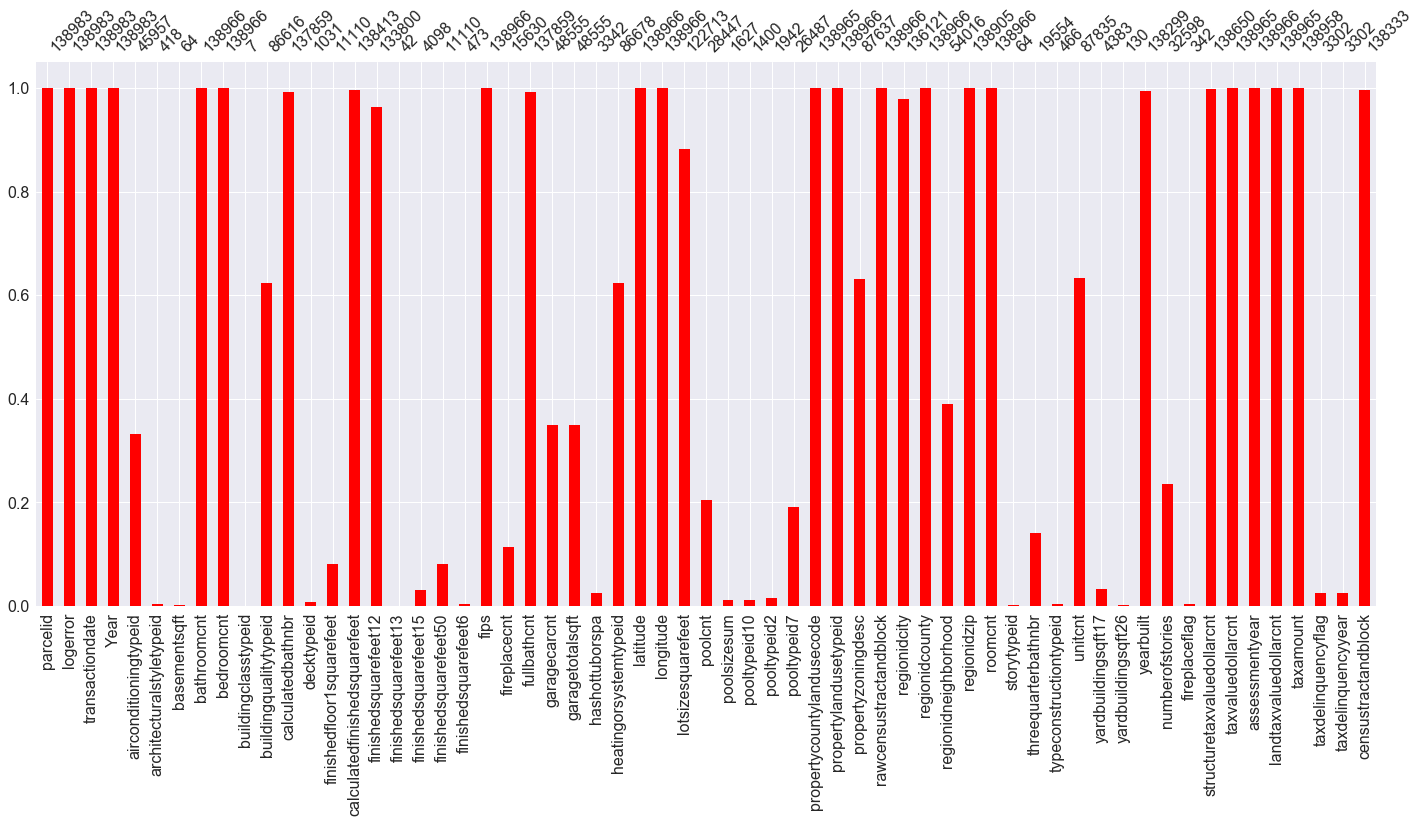

In [14]:
msno.bar(train_df, color = 'red')

In [15]:
train_df = train_df.dropna(axis=1, thresh=0.25 *167888)
train_df = train_df.dropna(axis=0, thresh = 0.25 * 36)

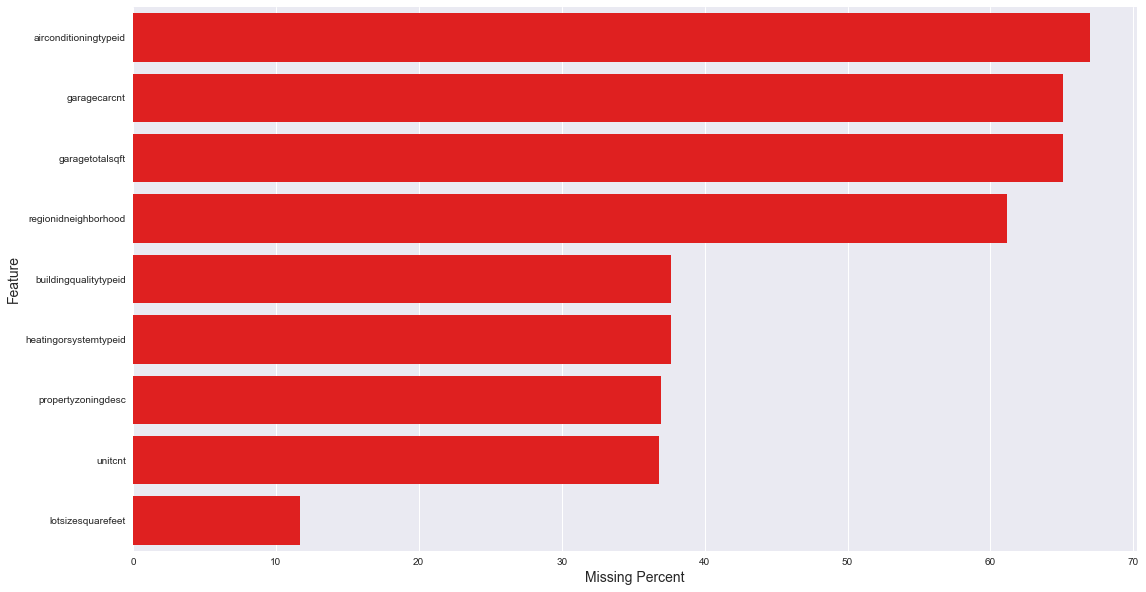

In [16]:
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['missing_percent'] = missing_df['missing_count'] * 100/ train_df.shape[0]
missing_df = missing_df[missing_df['missing_percent']>10]
missing_df = missing_df.sort_values(by='missing_percent',ascending = False).reset_index(drop = True)
plt.figure(figsize=(18,10))
sns.barplot(y = 'column_name', x = 'missing_percent', data = missing_df, color = 'red')
plt.xlabel('Missing Percent', fontsize = 14)
plt.ylabel('Feature' , fontsize = 14)
plt.show()

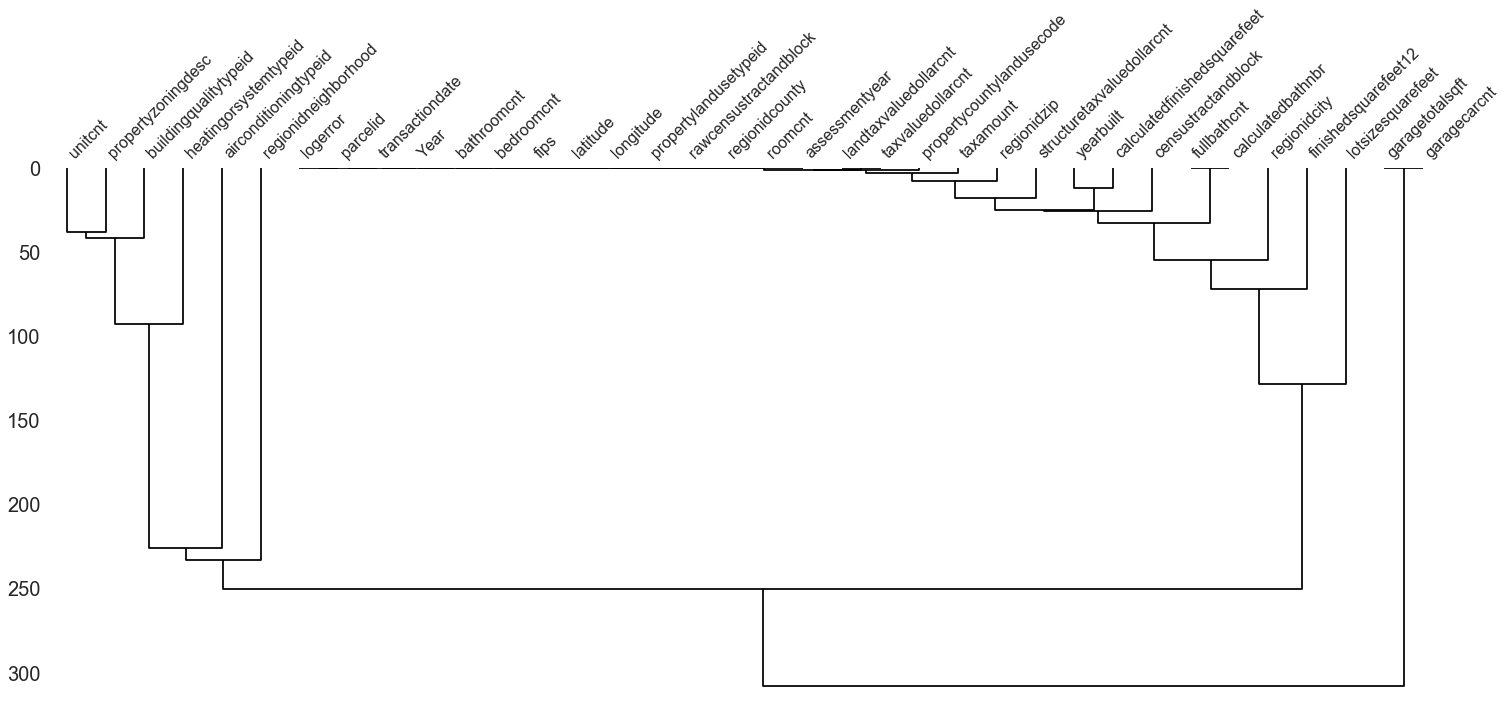

In [17]:
msno.dendrogram(train_df)

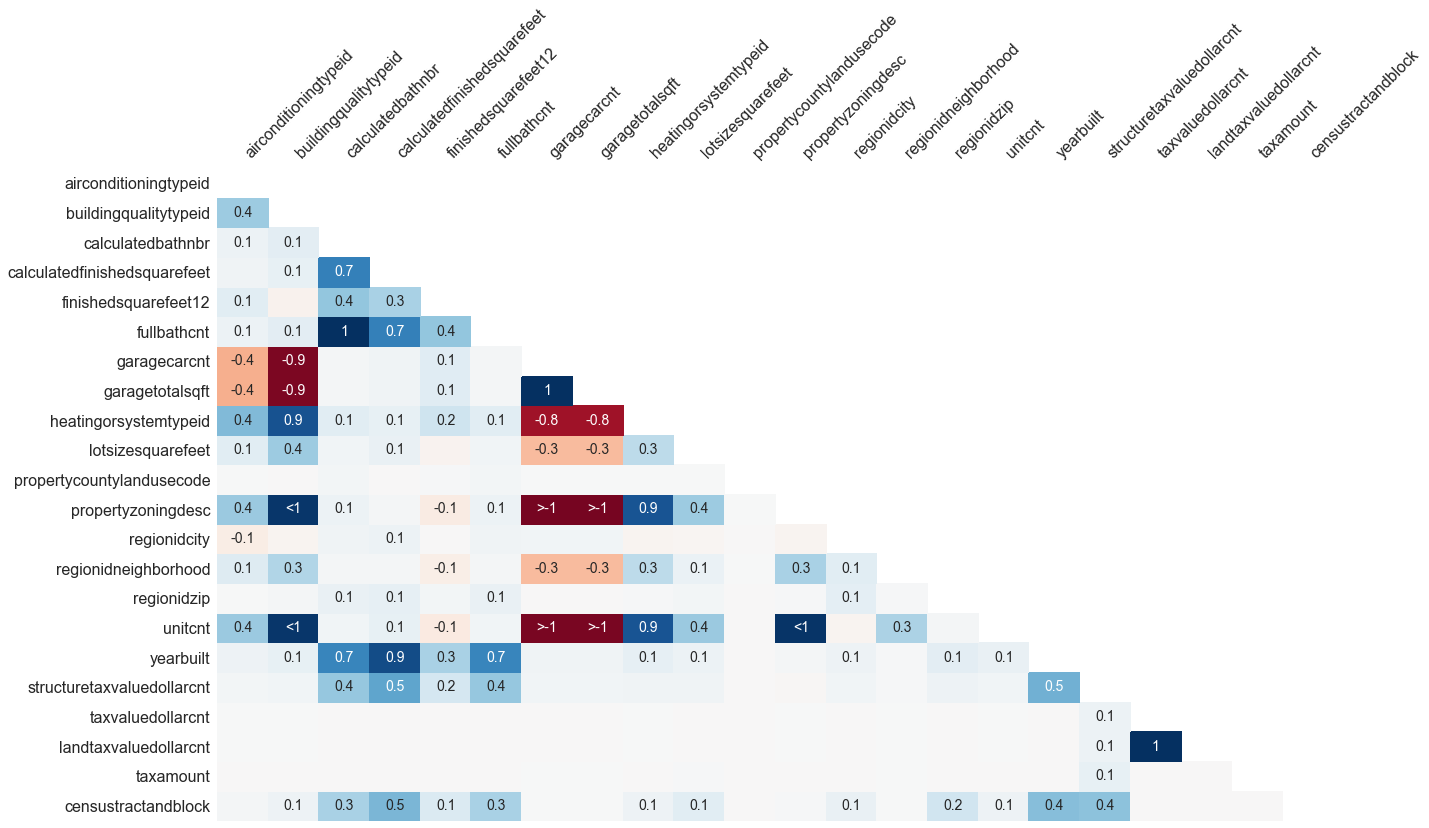

In [18]:
msno.heatmap(train_df)

In [19]:
rnhood_train_df = train_df[train_df['regionidneighborhood'].notnull()]
x_train,x_test,y_train,y_test = train_test_split(rnhood_train_df[['latitude','longitude']],rnhood_train_df[['regionidneighborhood']],random_state = 0)
rnhood_get = train_df[train_df['regionidneighborhood'].isnull()]
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train,y_train.values.ravel())
rnhood_get['regionidneighborhood'] = knn.predict(rnhood_get[['latitude','longitude']])

In [20]:
train_df = pd.concat([rnhood_train_df,rnhood_get], ignore_index = True)

In [21]:
ltsqft_train_df = train_df[train_df['lotsizesquarefeet'].notnull() & train_df['finishedsquarefeet12'].notnull()]
x_train,x_test,y_train,y_test = train_test_split(ltsqft_train_df[['latitude','longitude','finishedsquarefeet12']],ltsqft_train_df[['lotsizesquarefeet']],random_state = 0)
ltsqft_get = train_df[train_df['lotsizesquarefeet'].isnull() & train_df['finishedsquarefeet12'].notnull()]
knn = KNeighborsRegressor(n_neighbors=2)
knn.fit(x_train,y_train.values.ravel())
ltsqft_get['lotsizesquarefeet'] = knn.predict(ltsqft_get[['latitude','longitude','finishedsquarefeet12']])

In [22]:
train_df = pd.concat([ltsqft_train_df,ltsqft_get], ignore_index = True)

In [23]:
values = {'buildingqualitytypeid': mode(train_df['buildingqualitytypeid'])}
train_df.fillna(value=values, inplace=True).head()

,parcelid,logerror,transactiondate,Year,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,...,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock
0,11016594,0.027600,2016-01-01,2016,1.0,2.0,3.0,4.0,2.0,1684.0,...,96370.0,0.0,1.0,1959.0,122754.0,360170.0,2015.0,237416.0,6735.88,6.037107e+13
1,12098116,-0.004000,2016-01-01,2016,1.0,3.0,2.0,4.0,3.0,2217.0,...,96293.0,0.0,1.0,1940.0,61994.0,119906.0,2015.0,57912.0,11484.48,6.037464e+13
2,12643413,0.021800,2016-01-02,2016,1.0,2.0,2.0,4.0,2.0,839.0,...,96222.0,0.0,1.0,1987.0,171518.0,244880.0,2015.0,73362.0,3048.74,6.037296e+13
3,11672170,-0.016100,2016-01-03,2016,1.0,4.0,5.0,1.0,4.0,3080.0,...,96120.0,0.0,1.0,1995.0,559040.0,1090127.0,2015.0,531087.0,13428.94,6.037263e+13
4,12524288,-0.041900,2016-01-03,2016,NaN,1.0,1.0,7.0,1.0,597.0,...,96238.0,0.0,1.0,1970.0,56233.0,70316.0,2015.0,14083.0,913.17,6.037575e+13
5,10815909,0.010000,2016-01-03,2016,1.0,3.0,3.0,4.0,3.0,1727.0,...,96379.0,0.0,1.0,1950.0,108985.0,416279.0,2015.0,307294.0,5194.00,6.037140e+13
6,12453853,-0.038700,2016-01-03,2016,NaN,1.0,2.0,7.0,1.0,840.0,...,96239.0,0.0,1.0,1927.0,122952.0,260249.0,2015.0,137297.0,3211.31,6.037570e+13
7,10805063,0.001000,2016-01-03,2016,1.0,2.0,2.0,4.0,2.0,1045.0,...,96349.0,0.0,1.0,1966.0,135218.0,250245.0,2015.0,115027.0,3117.19,6.037140e+13
8,12524725,-0.053400,2016-01-03,2016,NaN,3.0,2.0,4.0,3.0,1329.0,...,96238.0,0.0,1.0,1983.0,117504.0,215097.0,2015.0,97593.0,2648.96,6.037577e+13
9,11104966,-0.039800,2016-01-03,2016,NaN,2.0,4.0,7.0,2.0,1144.0,...,96374.0,0.0,1.0,1961.0,176891.0,335093.0,2015.0,158202.0,4499.03,6.037920e+13


In [24]:
htsyid_train_df = train_df[train_df['heatingorsystemtypeid'].notnull() & train_df['finishedsquarefeet12'].notnull() & train_df['lotsizesquarefeet'].notnull() & train_df['buildingqualitytypeid'].notnull()]
x_train,x_test,y_train,y_test = train_test_split(htsyid_train_df[['latitude','longitude','finishedsquarefeet12', 'lotsizesquarefeet', 'buildingqualitytypeid']],htsyid_train_df[['heatingorsystemtypeid']],random_state = 0)
htsyid_get = train_df[train_df['heatingorsystemtypeid'].isnull() & train_df['finishedsquarefeet12'].notnull() & train_df['lotsizesquarefeet'].notnull() & train_df['buildingqualitytypeid'].notnull()]
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train,y_train.values.ravel())
htsyid_get['heatingorsystemtypeid'] = knn.predict(htsyid_get[['latitude','longitude','finishedsquarefeet12', 'lotsizesquarefeet', 'buildingqualitytypeid']])

In [25]:
train_df = pd.concat([htsyid_train_df,htsyid_get], ignore_index = True)

In [26]:
unitcnt_train_df = train_df[train_df['unitcnt'].notnull() & train_df['lotsizesquarefeet'].notnull() & train_df['buildingqualitytypeid'].notnull()]
x_train,x_test,y_train,y_test = train_test_split(unitcnt_train_df[['latitude','longitude','lotsizesquarefeet', 'buildingqualitytypeid']],unitcnt_train_df[['unitcnt']],random_state = 0)
unitcnt_get = train_df[train_df['unitcnt'].isnull() & train_df['lotsizesquarefeet'].notnull() & train_df['buildingqualitytypeid'].notnull()]
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train,y_train.values.ravel())
unitcnt_get['unitcnt'] = knn.predict(unitcnt_get[['latitude','longitude','lotsizesquarefeet', 'buildingqualitytypeid']])

In [27]:
train_df = pd.concat([unitcnt_train_df,unitcnt_get], ignore_index = True)

In [28]:
gtsqft_train_df = train_df[train_df['garagetotalsqft'].notnull()  & train_df['lotsizesquarefeet'].notnull() & train_df['buildingqualitytypeid'].notnull()& train_df['unitcnt'].notnull()]
x_train,x_test,y_train,y_test = train_test_split(gtsqft_train_df[['latitude','longitude','lotsizesquarefeet','buildingqualitytypeid','unitcnt']],gtsqft_train_df[['garagetotalsqft']],random_state = 0)
gtsqft_get = train_df[train_df['garagetotalsqft'].isnull() & train_df['lotsizesquarefeet'].notnull() & train_df['buildingqualitytypeid'].notnull()& train_df['unitcnt'].notnull()]
knn = KNeighborsRegressor(n_neighbors=4)
knn.fit(x_train,y_train.values.ravel())
gtsqft_get['garagetotalsqft'] = knn.predict(gtsqft_get[['latitude','longitude','lotsizesquarefeet','buildingqualitytypeid','unitcnt']])

In [29]:
train_df = pd.concat([gtsqft_train_df,gtsqft_get], ignore_index = True)

In [30]:
gccnt_train_df = train_df[train_df['garagecarcnt'].notnull()  & train_df['lotsizesquarefeet'].notnull() & train_df['buildingqualitytypeid'].notnull()& train_df['unitcnt'].notnull()]
x_train,x_test,y_train,y_test = train_test_split(gccnt_train_df[['latitude','longitude','lotsizesquarefeet','buildingqualitytypeid','unitcnt']],gccnt_train_df[['garagecarcnt']],random_state = 0)
gccnt_get = train_df[train_df['garagecarcnt'].isnull() & train_df['lotsizesquarefeet'].notnull() & train_df['buildingqualitytypeid'].notnull()& train_df['unitcnt'].notnull()]
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train,y_train.values.ravel())
gccnt_get['garagecarcnt'] = knn.predict(gccnt_get[['latitude','longitude','lotsizesquarefeet','buildingqualitytypeid','unitcnt']])

In [31]:
train_df = pd.concat([gccnt_train_df,gccnt_get], ignore_index = True)

In [32]:
actid_train_df = train_df[train_df['airconditioningtypeid'].notnull()  & train_df['lotsizesquarefeet'].notnull() & train_df['heatingorsystemtypeid'].notnull()]
x_train,x_test,y_train,y_test = train_test_split(actid_train_df[['latitude','longitude','lotsizesquarefeet','heatingorsystemtypeid']],actid_train_df[['airconditioningtypeid']],random_state = 0)
actid_get = train_df[train_df['airconditioningtypeid'].isnull() & train_df['lotsizesquarefeet'].notnull() & train_df['heatingorsystemtypeid'].notnull()]
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train,y_train.values.ravel())
actid_get['airconditioningtypeid'] = knn.predict(actid_get[['latitude','longitude','lotsizesquarefeet','heatingorsystemtypeid']])

In [79]:
train_df = pd.concat([actid_train_df,actid_get], ignore_index = True)

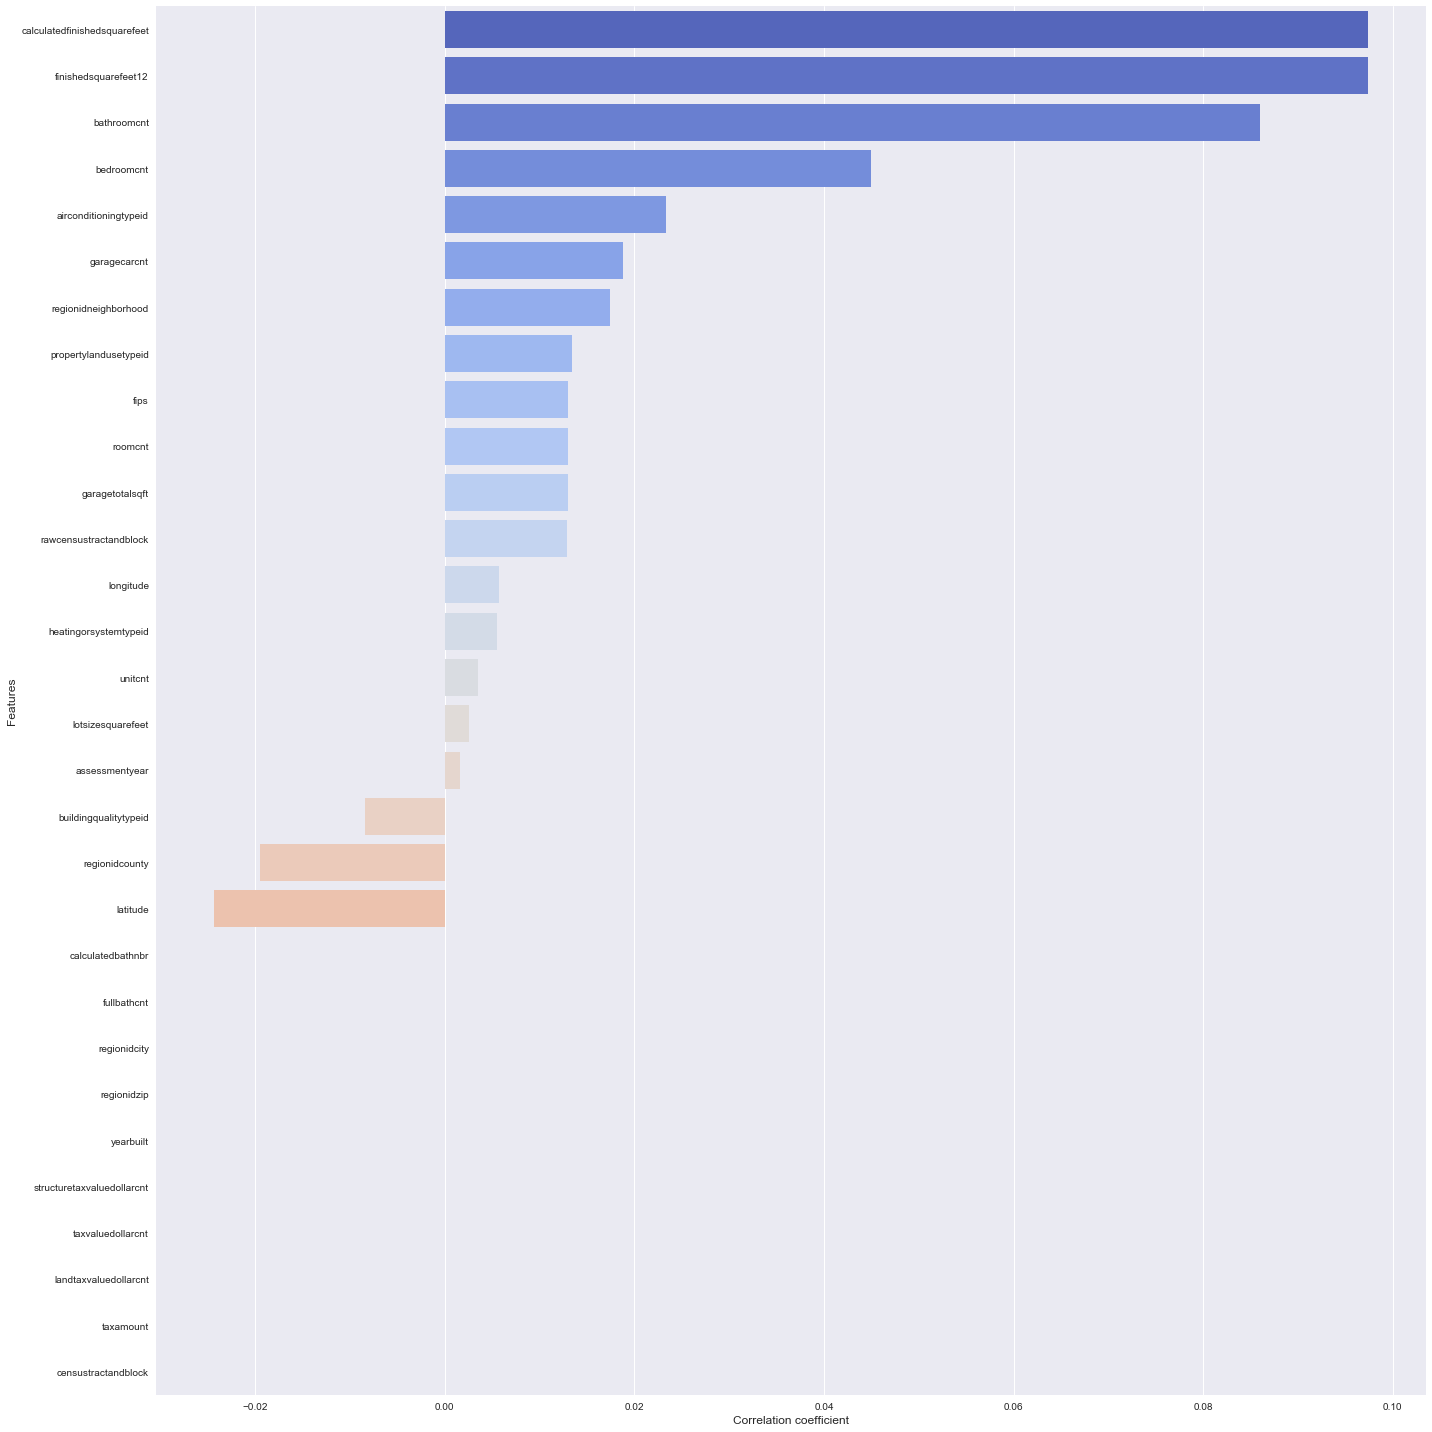

In [96]:
x_cols = [col for col in train_df.columns if col not in ['logerror'] if train_df[col].dtype=='float64']
labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(train_df[col].values, train_df.logerror.values)[0,1])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values', ascending=False)
plt.figure(figsize=(10,10))
sns.factorplot(x='corr_values', y='col_labels', data =corr_df, kind="bar", size=20, 
               aspect=1, palette='coolwarm')
plt.xlabel('Correlation coefficient', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.show()

In [35]:
train_df.drop(['transactiondate'], axis=1, inplace=True)
train_df.drop(['propertyzoningdesc'], axis=1, inplace=True)
train_df.drop(['Year'], axis=1, inplace=True)
train_df.drop(['propertycountylandusecode'], axis=1, inplace=True)
train_df = train_df.dropna(axis=0, thresh = 0.99 * 32)

In [36]:
train_df.shape

(130481, 32)

In [ ]:
X = train_df.drop(['logerror','latitude','longitude'], axis=1)
Y = train_df[['logerror']]
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0)

In [37]:
lr = LinearRegression()
lr.fit(x_train, y_train)
lr_predictions = lr.predict(x_test)
mean_absolute_error(y_test, lr_predictions)
math.sqrt(mean_squared_error(y_test, lr_predictions))

0.030058515605


In [47]:
regr = RandomForestRegressor(max_depth=4, n_jobs=-1, n_estimators=50, random_state=0)
regr.fit(x_train, y_train.values.ravel())
regr_predictions = regr.predict(x_test)
mean_absolute_error(y_test, regr_predictions)
math.sqrt(mean_squared_error(y_test, regr_predictions))

0.0155847771144


In [53]:
net = Sequential()
net.add(Dense(units=15,input_dim=29, activation='relu'))
net.add(Dense(units=1,input_dim=15, activation='relu'))
model.compile(optimizer=optimizers.SGD(lr=0.1),  loss='mean_squared_error', metrics=[metrics.mae])
model.fit(x_train.values, y_train.values, epochs=10)

Epoch 1/10
97860/97860 [==============================] - 3s 32us/step - loss: 0.0015 - mean_absolute_error: 0.0306
Epoch 2/10
97860/97860 [==============================] - 3s 27us/step - loss: 0.0015 - mean_absolute_error: 0.0306
Epoch 3/10
97860/97860 [==============================] - 3s 27us/step - loss: 0.0015 - mean_absolute_error: 0.0306
Epoch 4/10
97860/97860 [==============================] - 3s 26us/step - loss: 0.0015 - mean_absolute_error: 0.0306
Epoch 5/10
97860/97860 [==============================] - 3s 28us/step - loss: 0.0015 - mean_absolute_error: 0.0306
Epoch 6/10
97860/97860 [==============================] - 3s 28us/step - loss: 0.0015 - mean_absolute_error: 0.0306
Epoch 7/10
97860/97860 [==============================] - 3s 28us/step - loss: 0.0015 - mean_absolute_error: 0.0306
Epoch 8/10
97860/97860 [==============================] - 3s 28us/step - loss: 0.0015 - mean_absolute_error: 0.0306
Epoch 9/10
97860/97860 [==============================] - 3s 29us/step -

In [98]:
joblib.dump(regr,'best_model.pkl')

['best_model.pkl']

In [101]:
train_df.to_csv('train_df.csv', index=False)
public_key = ''
secret_key = ''
conn = S3Connection(public_key, secret_key)

try :
    fetched_bucket = conn.get_bucket('zillow-data')
    for k in fetched_bucket.list():
        k.delete()
    # delete all keys
    k = Key(fetched_bucket)
    k.key = 'train_df.csv'
    k.set_contents_from_filename('train_df.csv')
    k.set_acl('public-read')
    print('done')
except :
    print('bucket not found')
    new_bucket = conn.create_bucket('zillow-data', location = Location.SAEast)
    new_bucket.set_acl('public-read')
    k = Key(new_bucket)
    k.key = 'train_df.csv'
    k.set_contents_from_filename('train_df.csv')
    k.set_acl('public-read')

NameError: name 'S3Connection' is not defined